# Analyse dsync Notebook

## Abstract

Dans le cadre du projet d'analyse de la désynchronisation dans l'immprovisation musicale ...

## Experiments

The experiments were carried out over 3 sessions *data-yyyy-mm-dd*, with each session corresponding to a series of experiments *n__d_yyyy_mm_dd_t_hh_mm_ss*. 
There are 6 musicians, and each musician participating in the experiment has 2 acquisition devices (**riots**), one always on the head and the other on the arm or leg, depending on the session. There are therefore a total of 12 acquisition devices in an experiment. In addition, a trial (experiment) has 2 factors (or conditions)  

An acquisition device has :

* 3 sensors: accelerometer (**acc**) gyroscope (**gyro**) and magnetometer (**mag**) on 3 axes each
* 3 metrics : 
  **orientation** on 3 axes, device angle relative to gravitational axis
  * filtered acceleration (**accfilt**) on 3 axes, low-pass filter (~10 Hz) for accelerometer data to eliminate unwanted micro-variations
  **intensity**, normalization of the quantity of motion, "softened" representation of the recorded motion

There are therefore a total of 16 metrics per device per musician.

a sound file of the performance; depending on the session, this includes the sound of one or more metronomes, the sound "changes".

a video of the performance

a *riots-musicians.txt* file associating each riot with a musician and its type 

a *trials-info.txt* file associating the conditions of each experiment

A session also includes calibration recordings, improvisations and tests.

Translated with DeepL.com (free version)

## Datas

Stored in *.txt* format for each riot, sampled at 10ms, the data includes :

| Time Stamp | acc_x | acc_y | acc_z | gyro_x | gyro_y | gyro_z | mag_x | mag_y | mag_z | orientation_x | orientation_y | orientation_z | accfilt_x | accfilt_y | accfilt_z | intensity |
| ---------- | ----- | ----- | ----- | ------ | ------ | ------ | ----- | ----- | ----- | ------------- | ------------- | ------------- | --------- | --------- | --------- | --------- |

Data must be truncated in time, as they include biased data before and after performance.

## Code 

### Imports

#### Data Manipulation and Analysis

1.  **Numpy (`import numpy as np`)**: A fundamental package for numerical computing in Python.
    
2.  **Pandas (`import pandas as pd`)**: A library providing high-performance, easy-to-use data structures, and data analysis tools.

#### Data Visualization

1.  **Matplotlib (`import matplotlib.pyplot as plt`)**: A comprehensive library for creating static, interactive, and animated visualizations in Python.
    
2.  **Seaborn (`import seaborn as sns`)**: A statistical data visualization library based on Matplotlib.
    

#### Audio Processing

1.  **Librosa (`import librosa`, `import librosa.display`)**: A Python package for music and audio analysis.
    
2.  **SciPy (`from scipy import signal`, `import scipy as sp`)**: An open-source Python library used for scientific and technical computing. The `signal` module is specifically used for signal processing tasks, such as filtering or convolution.
    

#### File and System Operations

1.  **Glob (`import glob`)**: A module that finds all the pathnames matching a specified pattern according to the rules used by the Unix shell.
    
2.  **OS (`import os`)**: Provides a way of using operating system-dependent functionality.
    
3.  **Pickle (`import pickle`)**: Implements binary protocols for serializing and de-serializing a Python object structure.
    

#### Memory Management

1.   **Garbage Collector (`import gc`)**: Provides an interface to the garbage collector for Python objects.

#### Interactive Widgets and Displays

1.   **IPyWidgets (`import ipywidgets as widgets`, `from ipywidgets import interact, interactive, fixed, interact_manual`)**: Provides interactive HTML widgets for Jupyter notebooks. 
    
2.   **IPython Display (`from IPython.display import Audio, display, clear_output`)**: Facilitates rich media representation in Jupyter notebooks.
    
3.   **Regular Expressions (`import re`)**: Provides regular expression matching operations similar to those found in Perl.
    
4.   **Matplotlib Scale (`from matplotlib import scale`)**: While this specific import is unusual (as scales are typically used as part of plots directly), it might be aimed at customizing the scale of an axis in a plot.

### Data structures

Data structures must have a scalable organization, optimized to avoid redundancy and to speed up searching; the structure is "trivial" for other, lower-level programming languages.
Data structures can be organized as follows:

* class Session:
    * date: string (date)
    * experiences: dict of Experience (from 1 to 24 or 32 (number of trials))

* class Experience:
    * time: string (time)
    * number: int
    * musician_riots: dictionary { musician: (riot_head, riot_limb) }
    * riots: dict of Riot (instead of list)
    * factors: tuple of string ('same' | 'close' | 'high' | 'low' ,'Yes' | 'No' | 'All' | musician)

* class Riot:
    * dataset: dict Dataset (instead of list, from 0 to N)
    * duration : float
    * trunc: (start: float, end: float)
    * riot_type: "arm" | "leg" | "head"

* class Dataset:
    * t: float
    * acc_x: float
    * acc_y: float
    * acc_z: float
    * gyro_x: float
    * gyro_y: float
    * gyro_z: float
    * mag_x: float
    * mag_y: float
    * mag_z: float
    * orientation_x: float
    * orientation_y: float
    * orientation_z: float
    * accfilt_x: float
    * accfilt_y: float
    * accfilt_z: float
    * intensity: float

In [10]:
#imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme(style="darkgrid")
# sns.color_palette(palette="colorblind")

import scipy as sp
from scipy import signal
from scipy.signal import hilbert,hilbert2
from scipy.fft import fft,fftfreq
# from scipy.fftpack import *
import librosa
import librosa.display
import pywt #wavelet



import glob
import os
import pickle

import gc
import re

import ipywidgets as widgets 
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Audio, display, clear_output


class Session:
    def __init__(self, date, experiences=None):
        self.date = date
        if(experiences is None):
            experiences = {}
        self.experiences = experiences

class Experience:
    def __init__(self, time, number,musician_riots={},riots=None):
        self.time = time
        self.number = number
        # WARNING : Mutable default argument, all instance of experience point on the same instance of musician_riots dictionnary
        self.musician_riots = musician_riots
        if(riots is None):
            riots = {}
        self.riots = riots
        self.trunc = (0,0)
        self.info = ('','')

class Riot:
    def __init__(self, dataset, duration, riot_type):
        self.dataset = dataset
        self.duration = duration
        # trunc into experiences instead in riots
        # self.trunc = trunc
        self.riot_type = riot_type

class Dataset:
    def __init__(self, t, acc_x, acc_y, acc_z, gyro_x, gyro_y, gyro_z, mag_x, mag_y, mag_z, orientation_x, orientation_y, orientation_z, accfilt_x, accfilt_y, accfilt_z, intensity):
        self.t = t
        self.acc_x = acc_x
        self.acc_y = acc_y
        self.acc_z = acc_z
        self.gyro_x = gyro_x
        self.gyro_y = gyro_y
        self.gyro_z = gyro_z
        self.mag_x = mag_x
        self.mag_y = mag_y
        self.mag_z = mag_z
        self.orientation_x = orientation_x
        self.orientation_y = orientation_y
        self.orientation_z = orientation_z
        self.accfilt_x = accfilt_x
        self.accfilt_y = accfilt_y
        self.accfilt_z = accfilt_z
        self.intensity = intensity
        
    def __str__(self):
        return f"t: {self.t}, acc_x: {self.acc_x}, acc_y: {self.acc_y}, acc_z: {self.acc_z}, gyro_x: {self.gyro_x}, gyro_y: {self.gyro_y}, gyro_z: {self.gyro_z}, mag_x: {self.mag_x}, mag_y: {self.mag_y}, mag_z: {self.mag_z}, orientation_x: {self.orientation_x}, orientation_y: {self.orientation_y}, orientation_z: {self.orientation_z}, accfilt_x: {self.accfilt_x}, accfilt_y: {self.accfilt_y}, accfilt_z: {self.accfilt_z}, intensity: {self.intensity}"

# function to load data in object-based representation
def load_data(session_folder):
    # Extract date from folder name
    date = session_folder.split('-',1)[-1]
    session = Session(date)

    
    musicians_info_path = os.path.join(session_folder, 'riots-musicians.txt')
    musician_info = {}
    musician_riots = {}

    trials_info_path = os.path.join(session_folder, 'trials-info.txt')
    trials_info = []

    # Load musician and riot info
    with open(musicians_info_path, 'r') as file:
        for line in file:
            riot_number, musician, riot_type = line.strip().split()
            musician_info[int(riot_number)-1] = (musician, riot_type)
            
           # musician already in dict
            if musician not in musician_riots:
                musician_riots[musician] = (None, None)
            
            if riot_type == 'head':
                musician_riots[musician] = (int(riot_number)-1, musician_riots[musician][1])
            elif riot_type in ['arm', 'leg']:
                if musician_riots[musician][1] is None:
                    musician_riots[musician] = (musician_riots[musician][0], int(riot_number)-1)

     # Load trials info
    with open(trials_info_path, 'r') as file:
        for line in file:
            factor1, factor2 = line.strip().split()
            trials_info.append((factor1,factor2))
    
    # load experiment's datas
    for exp_file in glob.glob(f'{session_folder}/*-data-riot-*.txt'):
        exp_info = os.path.basename(exp_file).split('_')
        exp_number = int(exp_info[0])
        exp_time = re.search(r't_(\d+_\d+_\d+)-data', exp_file).group(1).replace('_', ':')
        riot_number = int(exp_info[-1].split('.')[0].split('-')[-1]) - 1
        
        experience = None
        if exp_number in session.experiences:
            experience = session.experiences[exp_number]
        else:
            experience = Experience(exp_time,exp_number)
            experience.musician_riots = musician_riots
            experience.info = trials_info[exp_number-1]
            session.experiences[exp_number] = experience
        
        # Read from each riots
        datasets = []
        with open(exp_file, 'r') as file:
            for line in file:
                data = list(map(float, line.strip().split()))
                dataset = Dataset(*data)
                datasets.append(dataset)
        
        duration = max([d.t for d in datasets])
        session.experiences[exp_number].trunc = (0,max(duration,session.experiences[exp_number].trunc[1]))
        
        riot = Riot(datasets, duration, musician_info[riot_number][1])
        session.experiences[exp_number].riots[riot_number] = riot
        
    return session



class Dataf(Dataset):
    def __init__(self,dataset,exp_n,riot_n,musician,riot_type,trials_info):
        Dataset.__init__(self,dataset.t,dataset.acc_x,dataset.acc_y,dataset.acc_z,dataset.gyro_x,dataset.gyro_y,dataset.gyro_z,dataset.mag_x,dataset.mag_y,dataset.mag_z,dataset.orientation_x,dataset.orientation_y,dataset.orientation_z,dataset.accfilt_x,dataset.accfilt_y,dataset.accfilt_z,dataset.intensity)
        self.exp_n = exp_n
        self.riot_n = riot_n
        self.musician = musician
        self.riot_type = riot_type
        self.factor1, self.factor2 = trials_info
        
def session_to_dataf(session):
    # Construire les objets Dataf en prenant compte du tronquage
    datasetsf = []

    # for exp in session.experiences:      
    #     experience = session.experiences[exp]
    #     for musician in list(experience.musician_riots.keys()):
    #         riot_head, riot_limb = experience.musician_riots[musician]
    #         datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type) for data in experience.riots[riot_head].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
    #         datasetsf = datasetsf + [Dataf(data,experience.number,riot_head,musician,experience.riots[riot_limb].riot_type) for data in experience.riots[riot_limb].dataset if (experience.trunc[0] <= data.t <=experience.trunc[1])]
    
    # Cette algo tiens compte du fait que les données sont rangé par ordre croissant
    for exp in session.experiences:      
        experience = session.experiences[exp]
        for musician in list(experience.musician_riots.keys()):
            riot_head, riot_limb = experience.musician_riots[musician]
            
            # Pour riot_head
            for data in experience.riots[riot_head].dataset:
                if data.t > experience.trunc[1]:
                    break  # Arrêtez l'itération si data.t dépasse la limite de temps supérieure
                if experience.trunc[0] <= data.t:
                    datasetsf.append(Dataf(data,experience.number,riot_head,musician,experience.riots[riot_head].riot_type,experience.info))
            
            # Pour riot_limb
            for data in experience.riots[riot_limb].dataset:
                if data.t > experience.trunc[1]:
                    break  # Arrêtez l'itération si data.t dépasse la limite de temps supérieure
                if experience.trunc[0] <= data.t:
                    datasetsf.append(Dataf(data,experience.number,riot_limb,musician,experience.riots[riot_limb].riot_type,experience.info))
    
    # Utilisation de l'introspection pour construire la liste des dictionnaires
    data_dicts = [vars(dataset) for dataset in datasetsf]

    # Création du DataFrame Pandas
    return pd.DataFrame(data_dicts)


# Get data from dataframe (return ref)
def get_data(df, riot_type=None, trial_n=None, musician=None,riot_n=None):
    query = pd.Series([True] * len(df))
    
    if riot_type is not None:
        query &= (df['riot_type'] == riot_type)
    if trial_n is not None:
        query &= (df['exp_n'] == trial_n)
    if musician is not None:
        query &= (df['musician'] == musician)
    if riot_n is not None:
        query &= (df['riot_n'] == riot_n)
    
    
    return df[query]

# return 
# 1 click tempo 2 mask attack 3 change
def get_onsets(session_number,trial=None):
    session_str = ""
    onsets_folder = "../data/onsets/"
    if(session_number == 1):
        session_str = "CT"
    if(session_number == 2):
        session_str = "MA"
    if(session_number == 3):
        session_str = "CH"
    
    # Construct the search pattern
    if trial == None:
        search_pattern = f"{onsets_folder}{session_str}_*.csv"
    else:
        search_pattern = f"{onsets_folder}{session_str}_{str(trial).zfill(2)}*.csv"

    # Find all matching files
    matching_files =  glob.glob(search_pattern)
    # Load each CSV into a DataFrame and store in a list of tuples : Musician Trial DF
    results = [(onset_csvname2musician(filename), re.search('\d+',filename)[0], pd.read_csv(filename).rename(columns={pd.read_csv(filename).columns[0]: 'onsets'})) for filename in matching_files]

    # return results
    return { (musician, int(trial)): df for musician, trial, df in results }

def onset_csvname2musician(csvname):
    if("Pno" in csvname):
        return "Piano"
    if("Sax" in csvname):
        return "Sax"
    if("Vlc" in csvname):
        return "Cello"
    if("MD" in csvname or "MG" in csvname):
        return "Accordion"
    if("Clar" in csvname):
        return "Clarinet"
    if("Tom" in csvname or "peau" in csvname or "OH" in csvname or "Snare" in csvname or "Kick" in csvname):
        return "Drum"
    
def create_combined_dataframe(data, factors_file):
    """
    Crée un DataFrame combiné à partir de données de musiciens et d'essais,
    et des informations de facteurs.

    :param data: Dictionnaire où les clés sont des tuples (musician, trial) et les valeurs sont des DataFrames.
    :param factors_file: Chemin vers le fichier contenant les facteurs (factor1, factor2).
    :return: DataFrame combiné.
    """
    # Charger le fichier de facteurs
    factors_df = pd.read_csv(factors_file, index_col=None,header=None, sep='\s+',names=['factor1', 'factor2','timecode'])
    print(factors_df)
    # Initialiser une liste pour stocker les DataFrames combinés
    combined_data = []

    # Parcourir les données
    for (musician, trial), df in data.items():
        # Ajouter les colonnes musician, trial, factor1, factor2
        df['musician'] = musician
        df['trial'] = trial
        df['factor1'] = factors_df.iloc[trial-1, 0]
        df['factor2'] = factors_df.iloc[trial-1, 1]
        
        # Réorganiser les colonnes
        df = df[['onsets', 'musician', 'trial', 'factor1', 'factor2']]
        
        # Ajouter le DataFrame à la liste
        combined_data.append(df)
    
    # Combiner tous les DataFrames en un seul
    final_df = pd.concat(combined_data, ignore_index=True)
    
    return final_df

            

### Datas loading

TODO C version to speedup

### Building Dataframe 

TODO

class Dataf (extend Dataset): 
  * exp_n: int
  * riot_n: int
  * musician: string
  * riot_type: "arm" | "leg" | "head"

### Exemple

Display waveform of the intensity of Cello over time in experience 10

In [3]:
#Load data in object based, convert to dataframe

# data_folder = "../data/"
# session2_folder = data_folder + 'data-2023-09-28'

# session = load_data(session2_folder)
# df = session_to_dataf(session)

In [4]:
# Plot Intensity of some riot

# filtered_df_Cello = df[(df['musician'] == 'Cello') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Cello, x='t', y='intensity', label='Intensity for Cello (Head) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Drum = df[(df['musician'] == 'Drum') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Drum, x='t', y='intensity', label='Intensity for Drum (Arm) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Sax = df[(df['musician'] == 'Sax') & (df['riot_type'] == 'arm') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Sax, x='t', y='intensity', label='Intensity for Sax (Arm) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# filtered_df_Sax = df[(df['musician'] == 'Piano') & (df['riot_type'] == 'head') & (df['exp_n'] == 10)]

# plt.figure(figsize=(20, 3))
# sns.lineplot(data=filtered_df_Sax, x='t', y='intensity', label='Intensity for Piano (Head) - Exp 10')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

### Make data preparation interactive

In [5]:
# interactive code to truncate datas
%matplotlib inline


data_folder = "../data/"
cache_folder = "../data/cache/"
session_folder = ""
session = None
df = None
sound_file_path = ""
session_folders = []

save_name = ""

# Sauvegarde

def save_session(session,str=''):
    global save_name
    if(save_name == ""):
        save_name = '../data/cache/data-' + session.date + str + '.pickle'
    else:
        save_name = '../data/cache/' + save_name + '.pickle'
    with open(save_name, 'wb') as fichier:
        pickle.dump(session, fichier)

def load_session(session_path):
    with open(session_path, 'rb') as fichier:
        return pickle.load(fichier)
    return None

# Widgets
# Liste tous les dossiers dans data_folder
session_folders = [f.name for f in os.scandir(data_folder) if f.is_dir()]
session_select = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'] + session_folders,
    description='Sessions:',
    disabled=False
)
saved_folders = [f for f in os.listdir(cache_folder) if f.endswith('.pickle')]
saved_select = widgets.Dropdown(
    options=['Sélectionnez une sauvegarde de session'] + saved_folders,
    description='Saves:',
    disabled=False
)
sound_dropdown = widgets.Dropdown(
    options=['Sélectionnez un dossier de session'],
    description='Fichiers son:',
    disabled=False,)

def update_sound_dropdown(session_folder):
    sound_files = sorted( [f for f in os.listdir(os.path.join(session_folder, 'sound')) if f.endswith('.aif')],key=lambda str: int(str.split('_',1)[0]))
    if sound_files:
        sound_dropdown.options = ['Sélectionnez un son'] + sound_files
    else:
        sound_dropdown.options = ['Aucun fichier trouvé']

def on_session_change(change):
    global df
    global session
    global session_folder
    session_folder = os.path.join(data_folder, change['new'])
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)
    print("chargement du dataframe ...")
    session = load_data(session_folder)
    df = session_to_dataf(session)
    # save_session(session)
    print("chargement du dataframe Terminé")
    
def on_saved_change(change):
    global df
    global session
    global session_folder
    
    print("chargement du dataframe ...")
    session = load_session(os.path.join(cache_folder, change['new']))
    df = session_to_dataf(session)
    # save_session(session)
    print("chargement du dataframe Terminé")
    session_folder = os.path.join(data_folder,'data-'+session.date)
    # Mise à jour du menu déroulant pour les fichiers sonores
    update_sound_dropdown(session_folder)
    
ui_active = False

def on_sound_change(change):
    global sound_file_path, ui_box, ui_active
    if change['new'] != 'Sélectionnez un son':
        if ui_active == False:
            ui_active = True
            display(ui_box)
            
        start_end_slider.unobserve(update_selection, names='value')
        sound_file_path = change['new']
        setup_waveform_trunc(os.path.join(data_folder, session_folder,"sound",sound_file_path))

# Widgets callback
session_select.observe(on_session_change, names='value')
saved_select.observe(on_saved_change, names='value')
sound_dropdown.observe(on_sound_change, names='value')

# Widgets display
display(session_select,saved_select)
display(sound_dropdown)

# Pour tronquer la waveform

# Lier la lecture à l'appui sur le bouton
def on_play_button_clicked(b):
    play_audio(start_end_slider.value[0], start_end_slider.value[1], audio, sr)


# Tronquage des datas

def on_trunc_button_clicked(b):
    global df, session
    # Tronquage directement à l'update de la selection, tout est donc Tronqué automatiquement
        #Màj de l'objet session directement (attention seconde -> milliseconde)
        # session.experiences[int(sound_file_path.split("_",1)[0])].trunc = (start_end_slider.value[0] * 1000, start_end_slider.value[1] * 1000)
        
    # Màj du dataframe
    print("mis à jour du dataframe ...")
    df = session_to_dataf(session)
    save_session(session)
    print("mis à jour du dataframe Terminé")


out = widgets.Output()

# Définir la fonction de lecture audio
def play_audio(start_time, end_time, audio, sr):
    display(Audio(data=audio[int(start_time * sr):int(end_time * sr)], rate=sr))

# Créer la fonction de mise à jour de la sélection
def update_selection(change):
    global session
    #Màj de l'objet session (attention seconde -> milliseconde)
    session.experiences[int(sound_file_path.split("_",1)[0])].trunc = (change['new'][0] * 1000, change['new'][1] * 1000)

    with out:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.axvspan(change['new'][0], change['new'][1], color='red', alpha=0.5)
        plt.show()
        
# Créer les widgets pour contrôler la lecture et le tronquage
start_end_slider = widgets.FloatRangeSlider(
    min=0, 
    step=0.01, 
    description='Time Range (s):',
    continuous_update=False,
)
start_end_slider.layout.width = '50%'
play_button = widgets.Button(description="Play")
trunc_button = widgets.Button(description="Trunc")
trunc_button.on_click(on_trunc_button_clicked)

play_button.on_click(on_play_button_clicked)

# textbox pour sauvegarde
def update_save_name(change):
    global save_name
    save_name = change['new']
    

save_tbox = widgets.Text(
    value=save_name,
    placeholder='Nom de Sauvegarde',
    description='Save:',
    disabled=False   
)
save_tbox.observe(update_save_name, names='value')


ui_box = widgets.VBox([start_end_slider, play_button, trunc_button,save_tbox, out], layout={'width': '100%'})

# Créer la fonction pour configurer et afficher le waveform avec les contrôles
def setup_waveform_trunc(audio_path):
    global audio, sr, session
    
    # Charger le fichier audio
    audio, sr = librosa.load(audio_path)

    # Mise à jour des widgets pour contrôler la lecture et le tronquage
    start_end_slider.max = len(audio) / sr
    start_end_slider.value=[session.experiences[int(sound_file_path.split("_",1)[0])].trunc[0]/1000, session.experiences[int(sound_file_path.split("_",1)[0])].trunc[1]/1000]
    # Lier la mise à jour de la sélection aux changements de valeur des curseurs
    start_end_slider.observe(update_selection, names='value')
    
    # Initialiser l'affichage
    with out:
        clear_output(wait=True)
        plt.figure(figsize=(10, 4))
        librosa.display.waveshow(audio, sr=sr, color='blue')
        plt.axvspan(start_end_slider.value[0], start_end_slider.value[1], color='red', alpha=0.5)
        plt.show()
    
# %matplotlib inline

Dropdown(description='Sessions:', options=('Sélectionnez un dossier de session', 'cache', 'csv', 'data-2023-09…

Dropdown(description='Saves:', options=('Sélectionnez une sauvegarde de session', 'change.pickle', 'click_temp…

Dropdown(description='Fichiers son:', options=('Sélectionnez un dossier de session',), value='Sélectionnez un …

### Load or Save CSV Dataframe

In [6]:
# interactive code to load/save csv
csv_path = '../data/csv/'

# Fonction pour charger les données CSV
def _load_csv(filename):
    global df
    full_path = os.path.join(csv_path, filename)
    if os.path.isfile(full_path):
        df = pd.read_csv(full_path)
        print("Fichier chargé avec succès. Aperçu des données :")
        display(df.head())
    else:
        print("Le fichier spécifié n'existe pas.")

def load_csv(filename):
    full_path = os.path.join(csv_path, filename)
    if os.path.isfile(full_path):
        dframe = pd.read_csv(full_path)
        print("Fichier chargé avec succès. Aperçu des données :")
        display(dframe.head())
        return dframe
    else:
        print("Le fichier spécifié n'existe pas.")
        return None

# Fonction pour sauvegarder les données dans un fichier CSV
def save_csv(b):
    file_name = save_text.value
    if file_name == '': return
    if df.empty:
        print("Le DataFrame est vide. Veuillez charger des données avant de sauvegarder.")
        return
    df.to_csv(os.path.join(csv_path, file_name + ".csv"), index=False)
    print(f"Les données ont été sauvegardées dans {file_name}.csv")

# Interface utilisateur pour le chargement de fichiers CSV
def file_selector(folder_path=csv_path):
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    selected_file = widgets.Dropdown(options=filenames, description='Fichiers CSV:')
    return selected_file

# Création du widget de sélection de fichier pour le chargement
file_dropdown = file_selector()
load_button = widgets.Button(description="Charger")
load_button.on_click(lambda b: _load_csv(file_dropdown.value))

# Création du widget de texte et bouton pour la sauvegarde
save_text = widgets.Text(
    value='',
    placeholder='Nom du fichier CSV',
    description='Sauver CSV:',
    disabled=False
)
save_button = widgets.Button(description="Sauvegarder")
save_button.on_click(save_csv)

# Affichage des widgets
display(file_dropdown, load_button, save_text, save_button)

# Interface utilisateur pour la sauvegarde de fichiers CSV
# interact(save_csv, file_name='')

Dropdown(description='Fichiers CSV:', options=('change_all.csv', 'change_intensity.csv', 'click_tempo_all.csv'…

Button(description='Charger', style=ButtonStyle())

Text(value='', description='Sauver CSV:', placeholder='Nom du fichier CSV')

Button(description='Sauvegarder', style=ButtonStyle())

#### ❗ Clear Memory

In [7]:
# add everything to free here
session = None
audio = None

columns_to_drop = ['acc_x' , 'acc_y' , 'acc_z' , 'gyro_x' , 'gyro_y' , 'gyro_z' , 'mag_x' , 'mag_y' , 'mag_z' , 'orientation_x' , 'orientation_y' , 'orientation_z' , 'accfilt_x' , 'accfilt_y' , 'accfilt_z']

def clear_df(df,columns):
    return df.drop(columns,axis=1)

plt.close('all')

# df = clear_df(df,columns_to_drop)

gc.collect()

4

## Analysis
basic statistics ,wavelet transform, correlation, cross-correlation, Fourrier Transform, spectral analysis, tempi/rhytmic analysis, Granger causality

### Distribution of movement

D'abord analyser la distribution du mouvement (pour une expérience) par instrument peut nous donner un bon indicateur d'à quel point certain mouvement de même amplitude sont important durant la performance 
Plus tard il faudrait distinguer les mouvements spontannées des mouvements de couplage avec le tempo


### Load dataframe of the 3 experiences

In [8]:
# CSV Intensitity

change_intensity = load_csv("change_intensity.csv")

mask_attack_intensity = load_csv("mask_attack_intensity.csv")

click_tempo_intensity = load_csv("click_tempo_intensity.csv")

df = click_tempo_intensity

Fichier chargé avec succès. Aperçu des données :


,t,intensity,exp_n,riot_n,musician,riot_type,factor1,factor2
0,3630.918226,0.077941,10,0,Cello,head,close,Cello
1,3640.918226,0.075531,10,0,Cello,head,close,Cello
2,3650.918226,0.073381,10,0,Cello,head,close,Cello
3,3660.918226,0.074477,10,0,Cello,head,close,Cello
4,3670.918226,0.079189,10,0,Cello,head,close,Cello


Fichier chargé avec succès. Aperçu des données :


,t,intensity,exp_n,riot_n,musician,riot_type,factor1,factor2
0,1561.099669,0.084687,10,0,Cello,head,low,No
1,1571.099669,0.082002,10,0,Cello,head,low,No
2,1581.099669,0.079899,10,0,Cello,head,low,No
3,1591.099669,0.079056,10,0,Cello,head,low,No
4,1601.099669,0.084792,10,0,Cello,head,low,No


Fichier chargé avec succès. Aperçu des données :


,t,intensity,exp_n,riot_n,musician,riot_type,factor1,factor2
0,5196.236472,0.089766,10,0,Cello,head,low,Yes
1,5206.236472,0.087023,10,0,Cello,head,low,Yes
2,5216.236472,0.091008,10,0,Cello,head,low,Yes
3,5226.236472,0.088336,10,0,Cello,head,low,Yes
4,5236.236472,0.091445,10,0,Cello,head,low,Yes


### Exemple

In [ ]:
filtered_df_mvDistrib = df[(df['exp_n'] == 10)]

g = sns.catplot(
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="riot_type",inner="quart" ,kind="violin",aspect=3,
)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()


In [ ]:
%matplotlib widget
filtered_df_mvDistrib = df[(df['riot_type'] == "head")]

g = sns.catplot(
    data=filtered_df_mvDistrib, x="musician", y="intensity", hue="exp_n",inner="quart" ,kind="violin",height=5,width=0.7,aspect=3,
)

g.figure.suptitle('Distribution of Intensity for each riot(Musician/Limb) - Exp 10' )

plt.show()

### Interactive Violin Plot

*How to use ?*

First, ensure you execute the code above to build and load the dataframe (Group 1), no need to manually load csv. Then, run this cell. You should wait approximately 30 seconds for the widgets to appear. Next, you can select your dataframe, trial numbers, riot type, and experiment factors, and then press 'Submit'. Press 'Reset' to clear all filters. You can group data using the 'Hue' dropdown.

(Note that the filters for all dataframe's factors are currently not working.)

In [ ]:
# Interactive violin plot
%matplotlib widget

# Initialize the MinMaxScaler
from pandas import DataFrame
from scipy.stats import zscore


# minmax_scaler = MinMaxScaler()
# zscore_scaler = StandardScaler()
# robust_scaler = RobustScaler()

def normalize_zscore(group):
    # group['intensity'] = zscore_scaler.fit_transform(group['intensity'])
    group['intensity'] = zscore(group['intensity'])
    return group

# Fonction pour normaliser avec Min-Max
def normalize_min_max(group):
    min_val = group['intensity'].min()
    max_val = group['intensity'].max()
    group['intensity'] = (group['intensity'] - min_val) / (max_val - min_val)
    return group

def normalize_rolling(df, window_size=500):
    # Calculer la moyenne et l'écart-type pour chaque fenêtre
    rolling_mean = df['intensity'].rolling(window=window_size, min_periods=1).mean()
    rolling_std = df['intensity'].rolling(window=window_size, min_periods=1).std()
    
    # Appliquer la normalisation
    df['intensity'] = (df['intensity'] - rolling_mean) / rolling_std

    df['intensity'] = df['intensity'].dropna()
    
    # Retourner le DataFrame normalisé
    return df

# Widgets pour les filtres

grouped_title = ""
trial_title = ""
riot_title = ""
f1_title = ""
f2_title = ""

dataframes = [click_tempo_intensity,mask_attack_intensity,change_intensity]
dataframes_str = ['click tempo', 'mask attack', 'change intensity']
selected_all = False
#worst thing to do
select_integer = -1


exp_n_widget = widgets.SelectMultiple(
    # options=sorted(df['exp_n'].unique()),
    value=[],
    description='Trial Numbers:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor1_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Complexities:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

factor2_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Parameters:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

riot_type_widget = widgets.SelectMultiple(
    # options=sorted(df['riot_type'].unique()),
    value=[],
    description='Riot Types:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='120px')
)

# Widget pour choisir la variable de catégorisation (hue)
hue_widget = widgets.Dropdown(
    options=['exp_n', 'riot_type','factor1','factor2'],
    value='exp_n',
    description='Hue:',
)

# chage options lost values (and labels)
def update_widget_options(widget, new_options):
    current_values = widget.value 
    widget.options = sorted(new_options)
    
    new_values = tuple(value for value in current_values if value in new_options)
    widget.value = new_values


def set_title(hue_value,exp_list,riot_list,f1_list,f2_list):
    global grouped_title, trial_title, riot_title
    if hue_value == 'exp_n':
        grouped_title = 'trial'
    elif hue_value == 'riot_type':
        grouped_title = 'riot type'
    elif hue_value == 'factor1':
        grouped_title = 'complexity'
    elif hue_value == 'factor2':
        grouped_title = 'parameters'
    
    if not exp_list:
        trial_title = 'All'
    else :
        trial_title = exp_list
    if not riot_list:
        riot_title = 'All'
    else :
        riot_title = riot_list
    if not f1_list:
        f1_title = 'All'
    else :
        f1_title = exp_list
    if not f2_list:
        f2_title = 'All'
    else :
        f2_title = riot_list

def update_violin_plot(*args):
    global df, select_integer,out
    filtered_dfs = []

    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())


    if selected_all == True:
        # Appliquer les filtres à chaque DataFrame de la liste
        for df_i in dataframes:
            if factor1_widget.value:
                df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
            if factor2_widget.value:
                df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
            if exp_n_widget.value:
                df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
            if riot_type_widget.value:
                df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
            filtered_dfs.append(df_i)
    else:
        # Appliquer les filtres
        df_i = df.copy()
        if factor1_widget.value:
            df_i = df_i[df_i['factor1'].isin(factor1_widget.value)]
        if factor2_widget.value:
            df_i = df_i[df_i['factor2'].isin(factor2_widget.value)]
        if exp_n_widget.value:
            df_i = df_i[df_i['exp_n'].isin(exp_n_widget.value)]
        if riot_type_widget.value:
            df_i = df_i[df_i['riot_type'].isin(riot_type_widget.value)]
        filtered_dfs.append(df_i)

    #doesn't display all filters options when all dataframes are selected
    update_widget_options(factor1_widget,df_i['factor1'].unique())
    update_widget_options(factor2_widget, df_i['factor2'].unique())
    update_widget_options(exp_n_widget,df_i['exp_n'].unique())
    update_widget_options(riot_type_widget,df_i['riot_type'].unique())

    if select_integer == -1 or select_integer == 3:
        select_integer = 0

    with out:
        plt.close('all')
        df_i_scale = DataFrame()
        clear_output(wait=True)
        for df_i in filtered_dfs:

            # scaling data per minMax
            df_i_scale = df_i.copy(deep=True)

            # normalize
            df_i_scale = df_i_scale.groupby('musician').apply(normalize_zscore,include_groups=False)
            # df_i_scale = df_i_scale.groupby('musician').apply(normalize_rolling)
            # df_i_scale = df_i_scale.groupby('musician').apply(normalize_min_max)


            sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
            g = sns.catplot(
                data=df_i_scale, x="musician", y="intensity", hue=hue_widget.value,
                palette="colorblind",
                kind="boxen",
                # kind="violin",
                # inner="quart",
                aspect=3,
            )
            set_title(hue_widget.value, exp_n_widget.label, riot_type_widget.label,factor1_widget.label,factor2_widget.label)
            g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - {} - Filtered by Trial: {}, Riot Type: {}, Complexity: {}, Parameter: {}'.format(
                grouped_title,dataframes_str[select_integer], trial_title, riot_title,f1_title,f2_title
            ))
            # g.set(ylim=(0, 1))
            # g.set(ylim=(-5, 15))

            # plt.savefig('violinplot.svg')
            plt.show()

            select_integer = select_integer + 1
#Chosir dataframe correspondant à la session
def update_df(selected_df):
    global df, selected_all, select_integer
    if selected_df == 'click tempo':
        df = click_tempo_intensity
        select_integer = 0
        selected_all = False
    elif selected_df == 'mask attack':
        df = mask_attack_intensity
        select_integer = 1
        selected_all = False
    elif selected_df == 'change':
        df = change_intensity
        select_integer = 2
        selected_all = False
    else:
        # df = pd.DataFrame()  # Réinitialise df si aucune sélection valide
        selected_all = True
        select_integer = -1
    update_violin_plot()

# Création du widget dropdown pour la sélection du DataFrame
df_selector = interactive(update_df, selected_df=['all','click tempo', 'mask attack', 'change'])


# Observeur pour la mise à jour UPDATE : Via Submit
# exp_n_widget.observe(update_violin_plot, 'value')
# riot_type_widget.observe(update_violin_plot, 'value')
# hue_widget.observe(update_violin_plot, 'value')
# factor1_widget.observe(update_violin_plot, 'value')
# factor2_widget.observe(update_violin_plot, 'value')

# Submit Button
submit_button = widgets.Button(description="Submit")
submit_button.on_click(update_violin_plot)

# Boutton Reset
reset_button = widgets.Button(description="Reset")
def on_reset_button_clicked(b):
    # Réinitialiser les valeurs des widgets à toutes les options sélectionnées
    print('reset')
    factor1_widget.value = ()
    factor2_widget.value = ()
    exp_n_widget.value = ()
    riot_type_widget.value = ()
    # factor1_widget.options = sorted(df['factor1'].unique())
    # factor2_widget.options = sorted(df['factor2'].unique())
    # riot_type_widget.options=sorted(df['riot_type'].unique())
    # exp_n_widget.options = sorted(df['exp_n'].unique())
    update_violin_plot()
reset_button.on_click(on_reset_button_clicked)

# Zone d'affichage pour le graphique
out = widgets.Output()

# Initialisation de l'affichage du graphique
update_violin_plot()

# Organiser et afficher les widgets
widgets_ui = widgets.VBox([df_selector,widgets.HBox([exp_n_widget, riot_type_widget]),widgets.HBox([factor1_widget,factor2_widget]), hue_widget
                           ,submit_button
                           ,reset_button
                           , out])
display(widgets_ui)

In [ ]:
# update_df('click_tempo')

# # Appliquer les filtres
# df_i = df.copy()

# sns.set_theme(context="notebook", palette="colorblind", style="darkgrid")
# g = sns.catplot(
#     data=df_i, x="musician", y="intensity", hue='exp_n',
#     palette="colorblind",
#     kind="violin", inner="quart", aspect=3,
# )
# set_title(hue_widget.value, [], [])
# g.figure.suptitle('Distribution of Intensity for each Musician Grouped by {} - Filtered by Trial: {}, Riot Type: {}'.format(
#     grouped_title, trial_title, riot_title
# ))
# g.set(ylim=(0, 1))

# # plt.savefig('violinplot.svg')
# plt.show()

### Mean Motion per Condition

I want to make statistics on the intensity of movement of musicians as a function of several factors, including the complexity of the rhythm being played and, for example, whether or not they have masks over their eyes.
The musicians are playing at the same time, so I need to be able to observe whether the movement of one affects the movement of the other.

For the moment I'm interested in the results ‘on average’. A hypothesis might be: on average, do musicians tend to move their unblindfolded eyes more when the complexity is high? 

However, the tendency of musicians to move depends on many factors such as the style of playing, the instrument and simply the musician's tendency to move. For example, a drummer moves much more than a clarinettist.

So the average movements with the mask, for example, will be biased, because they don't have the same tendency to move. I imagined standardised movements with the z-score.

My questions are, what's the procedure for putting all the musicians on an equal footing, how do you compare the different factors?


In [ ]:
from tokenize import group
from xml.etree.ElementInclude import include


def plot_and_save_barplot(dataframe, x_col,x_label, y_col,y_label, hue_col,hue_label, title, save_path,sns_palette="hls"):
    """
    Normalise le dataframe par z-score, crée un barplot et l'enregistre.

    Parameters:
    dataframe (pd.DataFrame): Le dataframe d'origine.
    x_col (str): La colonne à utiliser pour l'axe des x.
    x_label (str)
    y_col (str): La colonne à utiliser pour l'axe des y.
    y_label (str)
    hue_col (str): La colonne à utiliser pour la teinte (hue).
    hue_label (str)
    
    title (str): Le titre du plot.
    save_path (str): Le chemin où le plot sera enregistré.
    """
    # Copier le dataframe pour éviter de modifier l'original
    df_copy = dataframe.copy()

    # no more misinterprete with this coloring
    # Get sorted unique levels of factor1
    factor1_levels = sorted(df_copy['factor1'].unique())
    # Define a color palette for factor1 based on the sorted levels
    palette = sns.color_palette(sns_palette, len(factor1_levels))
    factor1_colors = {factor: palette[i] for i, factor in enumerate(factor1_levels)}
    # Define hue order and palette based on the sorted factor levels
    hue_order = factor1_levels
    hue_palette = [factor1_colors[key] for key in hue_order]

    # Normaliser les données par z-score
    df_copy = df_copy.groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

    # Créer le barplot
    plt.figure(figsize=(10, 6))
    axs = sns.barplot(data=df_copy, x=x_col, y=y_col,
                      estimator='mean', errorbar=("sd"),
                      hue=hue_col, capsize=.2,palette=hue_palette)
    
    for container in axs.containers:
        axs.bar_label(container, fmt='%.2f')
    
    # Ajouter les titres et étiquettes
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(f'Average {y_label} (zscore normalized)')
    plt.legend(title=hue_label)

    # Enregistrer le plot
    plt.savefig(save_path)
    plt.show()

def plot_and_save_barplot_noNorm(dataframe, x_col,x_label, y_col,y_label, hue_col,hue_label, title, save_path,sns_palette="hls"):
    """
    Normalise le dataframe par z-score, crée un barplot et l'enregistre.

    Parameters:
    dataframe (pd.DataFrame): Le dataframe d'origine.
    x_col (str): La colonne à utiliser pour l'axe des x.
    x_label (str)
    y_col (str): La colonne à utiliser pour l'axe des y.
    y_label (str)
    hue_col (str): La colonne à utiliser pour la teinte (hue).
    hue_label (str)
    
    title (str): Le titre du plot.
    save_path (str): Le chemin où le plot sera enregistré.
    """
    # Copier le dataframe pour éviter de modifier l'original
    df_copy = dataframe.copy()

    # no more misinterprete with this coloring
    # Get sorted unique levels of factor1
    factor1_levels = sorted(df_copy['factor1'].unique())
    print(len(factor1_levels))
    # Define a color palette for factor1 based on the sorted levels
    palette = sns.color_palette(sns_palette, len(factor1_levels))
    factor1_colors = {factor: palette[i] for i, factor in enumerate(factor1_levels)}
    # Define hue order and palette based on the sorted factor levels
    hue_order = factor1_levels
    hue_palette = [factor1_colors[key] for key in hue_order]

    # Créer le barplot
    plt.figure(figsize=(10, 6))
    axs = sns.barplot(data=df_copy, x=x_col, y=y_col,
                      estimator='mean', errorbar=("sd"),
                      hue=hue_col, capsize=.2,palette=hue_palette)
    
    for container in axs.containers:
        axs.bar_label(container, fmt='%.2f')
    
    # Ajouter les titres et étiquettes
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(f'Average {y_label} (zscore normalized)')
    plt.legend(title=hue_label)

    # Enregistrer le plot
    plt.savefig(save_path)
    plt.show()


#### Click Tempo

In [ ]:

plt.close('all')

# Average Intensity per  for each musician
plot_and_save_barplot(dataframe=click_tempo_intensity,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/click_tempo/ClickTempo_Average_Intensity_per_Complexity_and_Metronome_normalize.png"
                      ,x_label='Metronome'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
 
# Average Intensity per  for each musician head
plot_and_save_barplot(dataframe=click_tempo_intensity[(click_tempo_intensity['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/click_tempo/ClickTempo_Average_Intensity_per_Complexity_and_Metronome_head_normalize.png"
                      ,x_label='Metronome'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")
# Average Intensity per  for each musician arm
plot_and_save_barplot(dataframe=click_tempo_intensity[(click_tempo_intensity['riot_type'] == 'leg')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Leg Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/click_tempo/ClickTempo_Average_Intensity_per_Complexity_and_Metronome_leg_normalize.png"
                      ,x_label='Metronome'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="icefire")



In [ ]:


# df = click_tempo_all = load_csv("click_tempo_all.csv")
# df = df.groupby('musician').apply(normalize_zscore)

# # Maintenant, créons le bar plot avec Seaborn
# plt.figure(figsize=(10, 6))
# # sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
# sns.boxplot(data=df, x='musician', y='orientation_x',
#             # estimator='mean',errorbar=("sd"),
#               hue='factor1')
#             #   , capsize=.2)

# plt.title('Box plot Orientation X dispersion per Musician (zscore normalized)')
# plt.xlabel('Musician')
# plt.ylabel('Average Intensity')
# plt.legend(title='Complexity')

# plt.show()

# plt.figure(figsize=(10, 6))
# # sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
# sns.boxplot(data=df, x='musician', y='orientation_y',
#             # estimator='mean',errorbar=("sd"),
#               hue='factor1')
#             #   , capsize=.2)

# plt.title('Box plot Orientation Y dispersion per Musician (zscore normalized)')
# plt.xlabel('Musician')
# plt.ylabel('Average Intensity')
# plt.legend(title='Complexity')

# plt.show()

# plt.figure(figsize=(10, 6))
# # sns.barplot(data=grouped, x='factor1', y='mean', hue='factor2', yerr=grouped['sem'], capsize=.2)
# sns.boxplot(data=df, x='musician', y='orientation_z',
#             # estimator='mean',errorbar=("sd"),
#               hue='factor1')
#             #   , capsize=.2)

# plt.title('Box plot Orientation Z dispersion per Musician (zscore normalized)')
# plt.xlabel('Musician')
# plt.ylabel('Average Intensity')
# plt.legend(title='Complexity')

# plt.show()

#### Mask Attack

In [ ]:
plot_and_save_barplot(dataframe=mask_attack_intensity,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/mask_attack/MaskAttack_Average_Intensity_per_Complexity_and_Mask_normalize.png"
                      ,x_label='Mask'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Spectral")
plot_and_save_barplot(dataframe=mask_attack_intensity[(mask_attack_intensity['riot_type'] == ('head'))],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/mask_attack/MaskAttack_Average_Intensity_per_Complexity_and_Mask_head_normalize.png"
                      ,x_label='Mask'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Spectral")
plot_and_save_barplot(dataframe=mask_attack_intensity[(mask_attack_intensity['riot_type'] == ('arm'))],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and Metronome (zscore normalized)'
                      ,save_path="../graph/mask_attack/MaskAttack_Average_Intensity_per_Complexity_and_Mask_arm_normalize.png"
                      ,x_label='Mask'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Spectral")


#### Change

In [ ]:
plt.close('all')

#change piano head no data
change_intensity = change_intensity[~((change_intensity['riot_type'] == 'head') & (change_intensity['musician'] == 'Piano'))]


#global

plot_and_save_barplot(dataframe=change_intensity,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="bright")

plot_and_save_barplot(dataframe=change_intensity[(change_intensity['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_head_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="bright")
plot_and_save_barplot(dataframe=change_intensity[(change_intensity['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_arm_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="bright")

# # One vs All

change_intensity_onevsall = change_intensity.copy()
change_intensity_onevsall['factor2'] = np.where(change_intensity_onevsall['factor2'] != 'All', 'One', change_intensity_onevsall['factor2'])

change_intensity_onevsall = change_intensity_onevsall.groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)
# test = change_intensity_onevsall

plot_and_save_barplot_noNorm(dataframe=change_intensity_onevsall,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="hls")

plot_and_save_barplot_noNorm(dataframe=change_intensity_onevsall[(change_intensity_onevsall['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_head_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="hls")
plot_and_save_barplot_noNorm(dataframe=change_intensity_onevsall[(change_intensity_onevsall['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_arm_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="hls")


# before/after change WARNING need to normalize before (see cell end)

def read_time_codes(file_path):
    change_timestamp = {}

    # Lire le fichier ligne par ligne
    with open(file_path, 'r') as file:
        nline = 1
        for line in file:
            # Séparer les éléments sur chaque ligne
            parts = line.strip().split()
            if len(parts) == 3:
                # Les deux premiers éléments sont des chaînes (str), le troisième est un float
                # key = f"{parts[0]} {parts[1]}"
                time_code = float(parts[2])
                change_timestamp[nline] = time_code
            nline = nline +1 

    return change_timestamp

change_timestamp = read_time_codes("../data/data-2023-09-28/trials-info.txt")

# Créer deux DataFrames pour stocker les données avant et après le time code

def before_after_sort_df(df):
    before_time_code = pd.DataFrame()
    after_time_code = pd.DataFrame()
    # Séparer les données en fonction du time code pour chaque trial
    for exp_n, group in df.groupby('exp_n'):
        # print(exp_n)
        time_code = change_timestamp[exp_n]  # Obtenir le time code pour ce trial
        before = group[group['t'] < time_code]
        after = group[group['t'] >= time_code]
        
        before_time_code = pd.concat([before_time_code, before])
        after_time_code = pd.concat([after_time_code, after])

    return before_time_code,after_time_code

#normalize here
before_change,after_change = before_after_sort_df(change_intensity.copy().groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False))


# global

# before change
plot_and_save_barplot_noNorm(dataframe=before_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_head_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")
plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_arm_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

# after change
plot_and_save_barplot_noNorm(dataframe=after_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_head_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")
plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_arm_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set1")

# # One vs All

# #normalize here
# # before_change,after_change = before_after_sort_df(change_intensity_onevsall.copy().groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False))

#normalized before
before_change,after_change = before_after_sort_df(change_intensity_onevsall)

# before change
plot_and_save_barplot_noNorm(dataframe=before_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")

plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_head_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")
plot_and_save_barplot_noNorm(dataframe=before_change[(before_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (before signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_arm_before_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")

# after change
plot_and_save_barplot_noNorm(dataframe=after_change,x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")

plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'head')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Head Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_head_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")
plot_and_save_barplot_noNorm(dataframe=after_change[(after_change['riot_type'] == 'arm')],x_col='factor2',y_col='intensity',hue_col='factor1'
                      ,title='Average Arm Intensity per Complexity and who receive a change signal (after signal) (zscore normalized)'
                      ,save_path="../graph/change/Change_Average_Intensity_per_Complexity_and_Signal_OnevsAll_arm_after_normalize.png"
                      ,x_label='Who is Notified'
                      ,y_label='Intensity'
                      ,hue_label='Complexity'
                      ,sns_palette="Set2")


# # preuve qu'il faut normaliser avant de séparer les données
# plt.close('all')


df = (change_intensity_onevsall[(change_intensity_onevsall['musician'] == 'Cello') & (change_intensity_onevsall['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

plt.figure(figsize=(5, 2))
sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello")
plt.axhline(y=df['intensity'].mean(), color='blue', linestyle='--', linewidth=1, label=f'Mean')
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# before_change,after_change = before_after_sort_df(change_intensity_onevsall)


# plt.figure(figsize=(5, 2))
# df = (before_change[(before_change['musician'] == 'Cello') & (before_change['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello before",color='blue')
# plt.axhline(y=df['intensity'].mean(), color='b', linestyle='--', linewidth=1, label=f'Mean')
# df = (after_change[(after_change['musician'] == 'Cello') & (after_change['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello after",color='red')
# # plt.axhline(y=df['intensity'].mean(), color='r', linestyle='--', linewidth=1, label=f'Mean')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# df = pd.concat([(before_change[(before_change['musician'] == 'Cello') & (before_change['exp_n'] == 22)]),
#                  (after_change[(after_change['musician'] == 'Cello') & (after_change['exp_n'] == 22)])]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

# plt.figure(figsize=(5, 2))
# sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - trial 22 Cello")
# plt.axhline(y=df['intensity'].mean(), color='blue', linestyle='--', linewidth=1, label=f'Mean')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# before_change,after_change = before_after_sort_df((change_intensity_onevsall[(change_intensity_onevsall['musician'] == 'Cello') & (change_intensity_onevsall['exp_n'] == 22)]).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False))
# # before_change,after_change = before_after_sort_df(change_intensity_onevsall.copy().groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=True)) #doesn't work 


# plt.figure(figsize=(5, 2))
# # df = (before_change[(before_change['musician'] == 'Cello') & (before_change['exp_n'] == 22)])#doesn't work 
# sns.lineplot(data=before_change, x='t', y='intensity', label=f"Intensity - trial 22 Cello before",color='blue')
# plt.axhline(y=df['intensity'].mean(), color='b', linestyle='--', linewidth=1, label=f'Mean')
# # df = (after_change[(after_change['musician'] == 'Cello') & (after_change['exp_n'] == 22)])#doesn't work 
# sns.lineplot(data=after_change, x='t', y='intensity', label=f"Intensity - trial 22 Cello after",color='red')
# # plt.axhline(y=df['intensity'].mean(), color='r', linestyle='--', linewidth=1, label=f'Mean')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()

# # Calculate and print means for verification
# def calculate_means(df):
#     return df.groupby(['factor1', 'factor2'])['intensity'].mean().reset_index()
# # Verify consistency of the means
# def verify_consistency(overall_means, before_means, after_means):
#     print(overall_means)
#     print(before_means)
#     print(after_means)
#     consistency = True
#     for index, row in overall_means.iterrows():
#         factor1, factor2 = row['factor1'], row['factor2']
#         overall_mean = row['intensity']
#         before_mean = before_means[(before_means['factor1'] == factor1) & (before_means['factor2'] == factor2)]['intensity'].values[0]
#         after_mean = after_means[(after_means['factor1'] == factor1) & (after_means['factor2'] == factor2)]['intensity'].values[0]
        
#         if not (before_mean <= overall_mean <= after_mean or after_mean <= overall_mean <= before_mean):
#             print(f"Inconsistent means for factor1={factor1}, factor2={factor2}: overall={overall_mean}, before={before_mean}, after={after_mean}")
#             consistency = False
#     return consistency

# mean_whole = test['intensity'].mean()
# mean_before = before_change['intensity'].mean()
# mean_after = after_change['intensity'].mean()

# print(f"Mean of the whole series: {mean_whole}")
# print(f"Mean before the change: {mean_before}")
# print(f"Mean after the change: {mean_after}")

# # Ensure the means follow the expected relationship
# assert mean_before <= mean_whole <= mean_after or mean_after <= mean_whole <= mean_before, "Inconsistent means found!"

# consistent = verify_consistency(calculate_means(test), calculate_means(before_change), calculate_means(after_change))
# print(f"\nConsistency of means: {'Consistent' if consistent else 'Inconsistent'}")


# # Generate the data

# num_musicians = 2
# time_series_length = 500
# num_trials = 20

# # Generate the data
# data = {
#     'exp_n': np.repeat(np.arange(1, num_trials + 1), num_musicians * time_series_length),
#     't': np.tile(np.arange(time_series_length), num_musicians * num_trials),
#     'intensity': np.random.rand(num_musicians * time_series_length * num_trials),
#     'musician': np.tile(np.repeat(np.arange(1, num_musicians + 1), time_series_length), num_trials),
#     'factor1': np.random.choice(['close', 'same'], num_musicians * time_series_length * num_trials),
#     'factor2': np.random.choice(['All', 'One'], num_musicians * time_series_length * num_trials)
# }

# # change timestamp

# change_timestamp = {trial: np.random.randint(0, time_series_length) for trial in range(1, num_trials + 1)}

# df = pd.DataFrame(data).groupby('musician',group_keys=False).apply(normalize_zscore, include_groups=False)

# df1,df2 = before_after_sort_df(df)

# plot_and_save_barplot_noNorm(dataframe=df,x_col='factor2',y_col='intensity',hue_col='factor1'
#                       ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
#                       ,save_path="test.png"
#                       ,x_label='Who is Notified'
#                       ,y_label='Intensity'
#                       ,hue_label='Complexity')

# plot_and_save_barplot_noNorm(dataframe=df1,x_col='factor2',y_col='intensity',hue_col='factor1'
#                       ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
#                       ,save_path="test1.png"
#                       ,x_label='Who is Notified'
#                       ,y_label='Intensity'
#                       ,hue_label='Complexity')

# plot_and_save_barplot_noNorm(dataframe=df2,x_col='factor2',y_col='intensity',hue_col='factor1'
#                       ,title='Average Intensity per Complexity and who receive a change signal (zscore normalized)'
#                       ,save_path="test2.png"
#                       ,x_label='Who is Notified'
#                       ,y_label='Intensity'
#                       ,hue_label='Complexity')

# mean_whole = df['intensity'].mean()
# mean_before = df1['intensity'].mean()
# mean_after = df2['intensity'].mean()s

# print(f"Mean of the whole series: {mean_whole}")
# print(f"Mean before the change: {mean_before}")
# print(f"Mean after the change: {mean_after}")

# # Ensure the means follow the expected relationship
# assert mean_before <= mean_whole <= mean_after or mean_after <= mean_whole <= mean_before, "Inconsistent means found!"

# consistent = verify_consistency(calculate_means(df), calculate_means(df1), calculate_means(df2))
# print(f"\nConsistency of means: {'Consistent' if consistent else 'Inconsistent'}")



In [ ]:
# test du rolling zscore

plt.close('all')

def rolling_zscore(df, window_ms, time_column='t', value_column='intensity'):
    # Convert the DataFrame to ensure proper types
    df = df[[time_column, value_column]].copy()
    
    # Ensure the DataFrame is sorted by time
    df.sort_values(by=time_column, inplace=True)
    
    # Calculate the rolling window size in number of samples
    time_diffs = df[time_column].diff().dropna().values
    average_sample_interval = np.mean(time_diffs)
    window_size = int(window_ms / average_sample_interval)
    
    # Calculate the rolling mean and std
    rolling_mean = df[value_column].rolling(window=window_size).mean()
    rolling_std = df[value_column].rolling(window=window_size).std()
    
    # Compute the rolling Z-score
    df['rolling_zscore'] = (df[value_column] - rolling_mean) / rolling_std

    # Normalize the rolling Z-score between -1 and 1 (min/max)
    min_z = df['rolling_zscore'].min()
    max_z = df['rolling_zscore'].max()
    df['normalized_rolling_zscore'] = (df['rolling_zscore'] - min_z) / (max_z - min_z) 
    
    return df

# Paramètres des fenêtres
window_sizes_ms = [40000 / (n + 1) for n in range(10)]

# Génération des graphiques
fig, axs = plt.subplots(4, 1, figsize=(15, 20), sharex=True)

df = (change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['exp_n'] == 22)]).copy()

plt.figure(figsize=(15, 10))

# Tracer la courbe originale
plt.plot(df['t'], df['intensity'], label='Original Signal', color='black', linewidth=2)

# Tracer les courbes de Z-score roulant pour chaque taille de fenêtre
# for window_ms in window_sizes_ms:
#     result_df = rolling_zscore(df, window_ms)
#     plt.plot(result_df['t'], result_df['normalized_rolling_zscore'], label=f'Rolling Z-score (Window = {window_ms} ms)')

# Ajouter des titres et des étiquettes
plt.title('Rolling Z-score with Different Window Sizes')
plt.xlabel('Time (ms)')
plt.ylabel('Value / Z-score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#Chosir dataframe correspondant à la session
def update_df(selected_df):
    global df
    if selected_df == 'click tempo':
        df = click_tempo_intensity
    elif selected_df == 'mask attack':
        df = mask_attack_intensity
    elif selected_df == 'change intensity':
        df = change_intensity
    else:
        df = pd.DataFrame()  # Réinitialise df si aucune sélection valide
    update_violin_plot()

# Création du widget dropdown pour la sélection du DataFrame
df_selector = interactive(update_df, selected_df=['click tempo', 'mask attack', 'change intensity'])



### Tempis


In [ ]:
# df = change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['riot_type'] == 'arm') & (change_intensity['exp_n'] == 10)]
# df = df['intensity'].to_numpy()

# plt.figure(figsize=(12,8))
# Tgram = librosa.feature.tempogram(y=df, sr=10000)
# librosa.display.specshow(Tgram, x_axis='time', y_axis='tempo')
# plt.colorbar()
# plt.title('Tempogram')
# plt.show()

df = change_intensity[(change_intensity['musician'] == 'Cello') & (change_intensity['riot_type'] == 'arm') & (change_intensity['exp_n'] == 10)]
df = df['intensity'].to_numpy()

from scipy  import signal

frequencies, power =  signal.periodogram(df, 100)

# Affichage du périodogramme
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, power)
plt.title('Périodogramme du signal')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.grid(True)
plt.show()

# import numpy as np


# signal = filtered_df_Cello['intensity'].to_numpy()
# # Normalisation du signal
# signal = signal - np.mean(signal)
# signal = signal / np.max(np.abs(signal))

# # Définir le taux d'échantillonnage
# sr = 100  # Le taux d'échantillonnage est de 100 Hz
# # tempo, _ = librosa.beat.beat_track(y=signal, sr=sr, tightness=100, trim=False)
# # Utiliser librosa.beat.tempo pour estimer le tempo global du signal
# # On utilise aggregate=None pour obtenir la distribution de tous les tempos estimés plutôt qu'un seul tempo global
# tempo_distribution = librosa.beat.tempo(y=signal, sr=sr, aggregate=None)

# # Visualiser la distribution du tempo
# plt.figure(figsize=(10, 6))
# plt.hist(tempo_distribution, bins=30, color='blue', alpha=0.7)
# plt.title('Distribution du Tempo')
# plt.xlabel('Tempo (battements par minute)')
# plt.ylabel('Fréquence')
# plt.show()

## Signal analysis

Dans cette partie nous allons réaliser les analyses de signaux relatif au mouvement. Pour cela nous allons comparer différentes méthode de traitement en utilisant les onsets temporelle extrait [des expériences pour chaque musicien](../Reaper/README.md)

In [11]:
onsets_ct_all = create_combined_dataframe(get_onsets(1),"../data/data-2023-09-26/trials-info.txt")
onsets_ma_all = create_combined_dataframe(get_onsets(2),"../data/data-2023-09-27/trials-info.txt")

onsets_ct_all.to_csv("../data/onsets/click_tempo_onsets.csv")
onsets_ma_all.to_csv("../data/onsets/mask_attack_onsets.csv")

   factor1 factor2  timecode
0     same      No       NaN
1     high      No       NaN
2      low     Yes       NaN
3    close     Yes       NaN
4      low      No       NaN
5     same     Yes       NaN
6     high     Yes       NaN
7    close      No       NaN
8     same     Yes       NaN
9      low     Yes       NaN
10     low      No       NaN
11    high     Yes       NaN
12   close      No       NaN
13   close     Yes       NaN
14    high      No       NaN
15    same      No       NaN
16    high      No       NaN
17     low     Yes       NaN
18    high     Yes       NaN
19   close      No       NaN
20   close     Yes       NaN
21     low      No       NaN
22    same      No       NaN
23    same     Yes       NaN
24     low      No       NaN
25    high      No       NaN
26    high     Yes       NaN
27    same      No       NaN
28    same     Yes       NaN
29   close     Yes       NaN
30     low     Yes       NaN
31   close      No       NaN
   factor1 factor2  timecode
0      low    

    Absolute Time (s)
0                 NaN
1            1.108729
2            1.001209
3            1.119250
4            0.885729
5            0.836854
6            0.992604
7            1.062813
8            1.083500
9            0.994083
10           0.988354
11           0.998021
12           0.965292
13           0.947562
14           1.011375
15           1.000250
16           0.997688
17           0.989729
18           1.047875
19           0.991229
20           1.036521
21           1.012562
22           0.971813
23           1.034229
24           1.154312
25           0.932063
26           0.864917
27           0.930249
28           0.930042
29           1.042250
30           0.991979
31           1.038500
32           0.952605
33           1.047999
34           0.953334
35           1.015229
36           1.069417
37           0.919833
38           1.043792
39           0.994646
40           0.983937
41           1.083313
42           1.024520
43           0.882292
44        

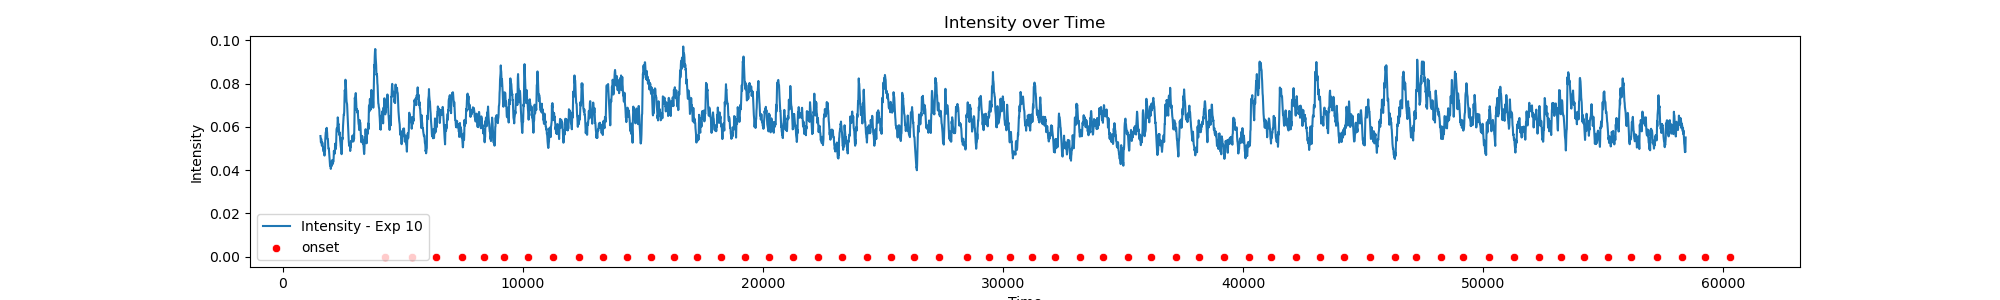

AttributeError: 'float' object has no attribute 'lower'

In [9]:
# %matplotlib inline
%matplotlib widget

plt.close('all')

# test get onsets
onsets_ma_10 = []
onsets_ma_10 = get_onsets(2,10)

# print(onsets_ma_10)


# tmp=  onsets_ma_10[4][1].diff()

# onset = onsets_ma_10[4][1]
# onset['t'] = onset['Absolute Time (s)']*1000 
# print(tmp)



# test with mask attack 10

# df = mask_attack_intensity[(mask_attack_intensity['riot_n'] == 1) & (mask_attack_intensity['exp_n'] == 10)] #Cello arm
# df = click_tempo_intensity[(click_tempo_intensity['musician'] == 'Piano') & (click_tempo_intensity['riot_type'] == 'head') & (click_tempo_intensity['exp_n'] == 22)] #Cello arm
df = get_data(mask_attack_intensity,riot_n=10,trial_n=10)
N = len(df)  # Nombre de points
T =  0.010 #df['t'][1] - df['t'][0]  # Intervalle de temps entre deux points (supposons qu'il est constant)
fs = 1 / T  # Fréquence d'échantillonnage

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='t', y='intensity', label=f"Intensity - Exp 10")
sns.scatterplot(data=onset,x='t',y=0,label="onset",color="red")
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()

# high pass filter

#coeffs
# order = 4
# cutoff = 0.1 # 10%
# b, a = signal.butter(order, cutoff,fs = fs, btype='high', analog=False) #Butterworth filter
def highpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    sos = signal.butter(poles, cutoff, 'highpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data
def lowpass(data: np.ndarray, cutoff: float, sample_rate: float, poles: int = 4):
    sos = signal.butter(poles, cutoff, 'lowpass', fs=sample_rate, output='sos')
    filtered_data = signal.sosfiltfilt(sos, data)
    return filtered_data
# def bandpass(data: np.ndarray, lowcut: float,highcut: float, sample_rate: float, poles: int = 2):
#     sos = signal.butter(poles, lowcut,highcut, 'bandpass', fs=sample_rate, output='sos')
#     filtered_data = signal.sosfiltfilt(sos, data)
#     return filtered_data

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

# plot Frequency response
# w, h = signal.freqz(b, a)
# plt.figure(figsize=(10, 6))
# plt.plot(w / np.pi, 20 * np.log10(abs(h)), color='blue')
# plt.title('Réponse en fréquence du filtre passe-haut')
# plt.xlabel('Fréquence normalisée (×π rad/échantillon)')
# plt.ylabel('Amplitude (dB)')
# plt.grid()
# plt.show()

# il doit y avoir des plages de valeurs typiques de mouvement oscillant (cf un papier que je lisais)

# plot filtered signal
# filtered_df = highpass(df['intensity'].values,0.08,fs)
filtered_df = bandpass(df['intensity'].values,0.9,1.1,fs)
# filtered_df = lowpass(highpass(df['intensity'].values,10,fs),10,fs)

plt.figure(figsize=(20, 3))
plt.plot(df['t'], filtered_df, label='Signal filtré (passe-haut)', color='orange')
sns.scatterplot(data=onset,x='t',y=0,label="onset",color="red")
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.legend()
plt.show()
# plot filtered signal
# filtered_df = lowpass(df['intensity'].values,10,fs)

# plt.figure(figsize=(20, 3))
# plt.plot(df['t'], filtered_df, label='Signal filtré (passe-bas)', color='orange')
# plt.title('Intensity over Time')
# plt.xlabel('Time')
# plt.ylabel('Intensity')
# plt.legend()
# plt.show()


# frequency spetrum


# Calcul de la Transformée de Fourier
yf = fft(df['intensity'].values)
xf = fftfreq(N, T)[:N//2]

# Tracer le spectre en fréquence
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Spectre en fréquence')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')  # Axe des fréquences en logarithmique
plt.yscale('log')  # Axe des amplitudes en logarithmique
plt.grid()
plt.show()

# Calcul de la Transformée de Fourier
yf = fft(filtered_df)
xf = fftfreq(N, T)[:N//2]
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.title('Spectre en fréquence')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
plt.xscale('log')  # Axe des fréquences en logarithmique
plt.yscale('log')  # Axe des amplitudes en logarithmique
plt.grid()
plt.show()

# Tracer le spectre en fréquence
fig, ax = plt.subplots(figsize=(20, 3))
# plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# plt.title('Spectre en fréquence')
# plt.xlabel('Fréquence (Hz)')
# plt.ylabel('Amplitude')
# plt.xscale('log')  # Axe des fréquences en logarithmique
# plt.yscale('log')  # Axe des amplitudes en logarithmique
# plt.grid()
# plt.show()
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
# plt.legend()
plt.grid()

@widgets.interact(cutoff=(0.001,1,0.001))
def update_filter(cutoff = 0.08):
    global df,fs
    [l.remove() for l in ax.lines]
    filtered_df = highpass(df['intensity'].values,cutoff,fs)
    plt.plot(df['t'], filtered_df, label='Signal filtré (passe-haut)', color='orange')
    yf = fft(filtered_df)
    xf = fftfreq(N, T)[:N//2]
    plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))

# # Calcul du spectrogramme STFT
# plt.figure(figsize=(10, 6))
# f, t, Sxx = signal.spectrogram(df['intensity'].values, fs)
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Spectrogramme STFT')
# plt.colorbar(label='Intensity [dB]')
# plt.show()

# # Calcul du spectrogramme STFT
# plt.figure(figsize=(10, 6))
# f, t, Sxx = signal.spectrogram(filtered_df, fs),1000,1
# plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Spectrogramme STFT')
# plt.colorbar(label='Intensity [dB]')
# plt.show()


    

# # Calcul du scalogramme
# widths = np.arange(1, 128)
# cwtmatr, freqs = pywt.cwt(df['intensity'].values, widths, 'cmor', sampling_period=1/fs)
# plt.imshow(20 * np.log10(abs(cwtmatr)), extent=[0, 10, 1, 128], cmap='viridis', aspect='auto', vmax=0)
# plt.yscale('log')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Scalogramme')
# plt.colorbar(label='Intensity [dB]')
# plt.show()

# # Calcul du scalogramme
# widths = np.arange(1, 128)
# cwtmatr, freqs = pywt.cwt(filtered_df, widths, 'cmor', sampling_period=1/fs)
# plt.imshow(20 * np.log10(abs(cwtmatr)), extent=[0, 10, 1, 128], cmap='viridis', aspect='auto', vmax=0)
# plt.yscale('log')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.title('Scalogramme')
# plt.colorbar(label='Intensity [dB]')
# plt.show()



#hilbert test
# Compute the analytic signal using the Hilbert transform
# analytic_signal = hilbert(filtered_df)
# envelope = np.abs(analytic_signal)
# instantaneous_phase = np.unwrap(np.angle(analytic_signal))
# instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi) * fs

# # Plot the results
# plt.figure(figsize=(12, 8))

# # # Plot the original signal
# # plt.subplot(3, 1, 1)
# # plt.plot(df['t'], filtered_df, label='AM Signal')
# # plt.title('Original Signal')
# # plt.xlabel('Time [s]')
# # plt.ylabel('Amplitude')
# # plt.legend()

# # Plot the envelope
# plt.subplot(3, 1, 1)
# plt.plot(df['t'], envelope, label='Envelope', color='orange')
# plt.title('Envelope of the Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')
# plt.legend()

# Plot the instantaneous phase and frequency
# plt.subplot(3, 1, 2)
# plt.plot(df['t'][:-1], instantaneous_frequency, label='Instantaneous Frequency', color='green')
# plt.title('Instantaneous Frequency of the Signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Frequency [Hz]')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(20, 3))
# plt.plot(xf, 2.0/N * np.abs(yf[:N//2]))
# plt.title('Spectre en fréquence')
# plt.xlabel('Fréquence (Hz)')
# plt.ylabel('Amplitude')
# plt.xscale('log')  # Axe des fréquences en logarithmique
# plt.yscale('log')  # Axe des amplitudes en logarithmique
# plt.grid()
# plt.show()
plt.title('Intensity over Time')
plt.xlabel('Time')
plt.ylabel('Intensity')
# plt.legend()
plt.grid()

@widgets.interact(cutoff=(0.001,1,0.001))
def update_filter(cutoff = 0.08):
    global df,fs
    [l.remove() for l in ax.lines]
    filtered_df = highpass(df['intensity'].values,cutoff,fs)
    plt.plot(df['t'], filtered_df, label='Signal filtré (passe-haut)', color='orange')

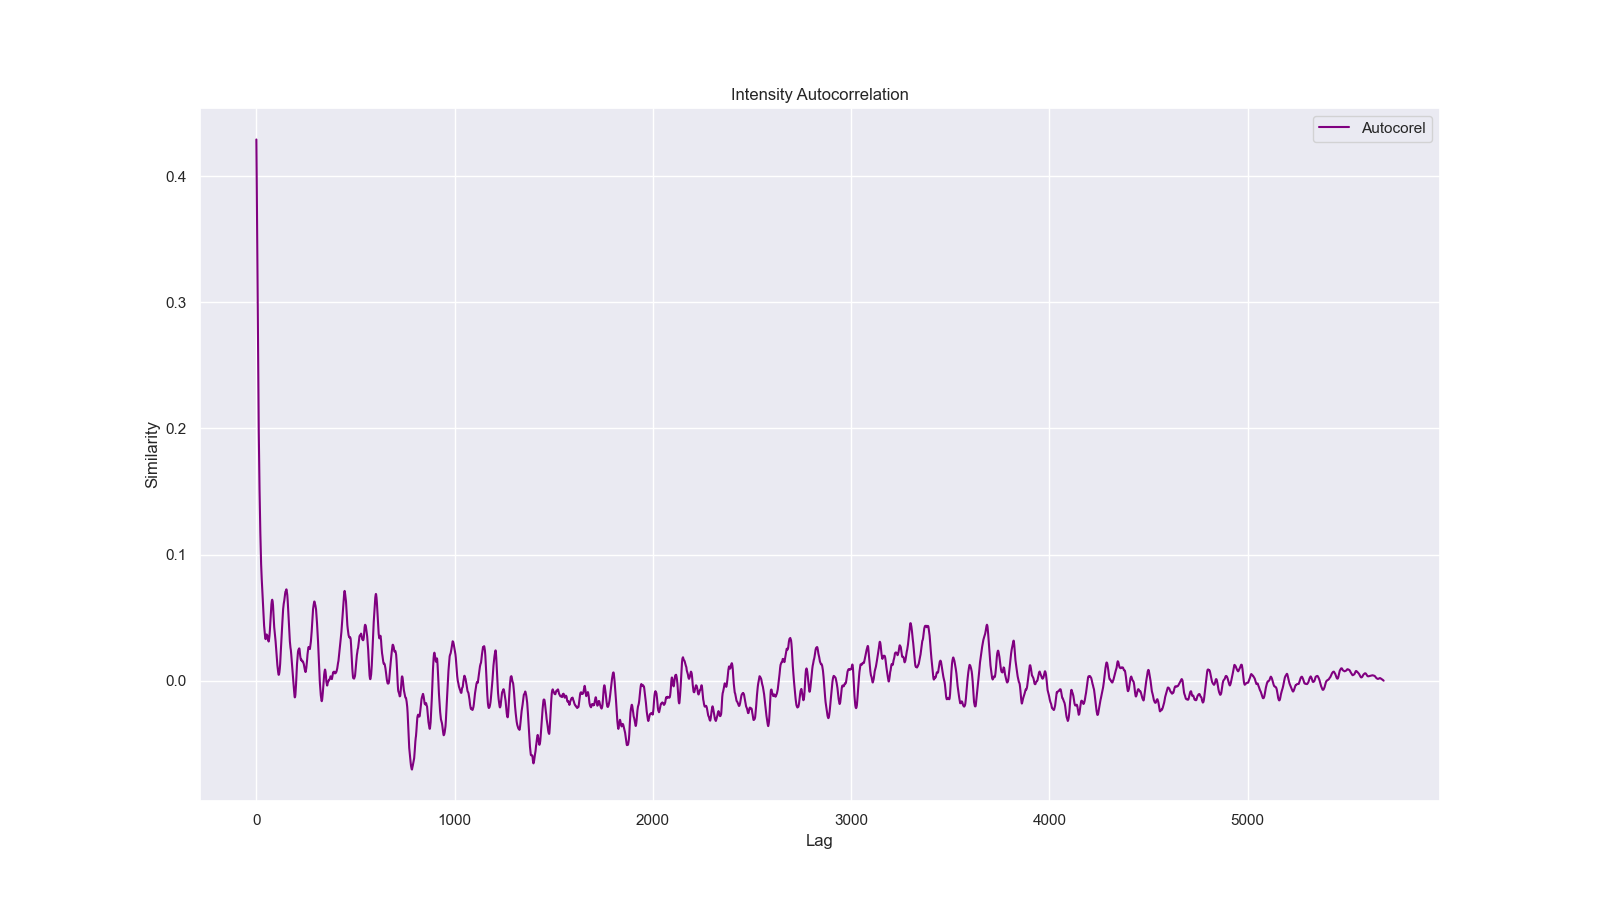

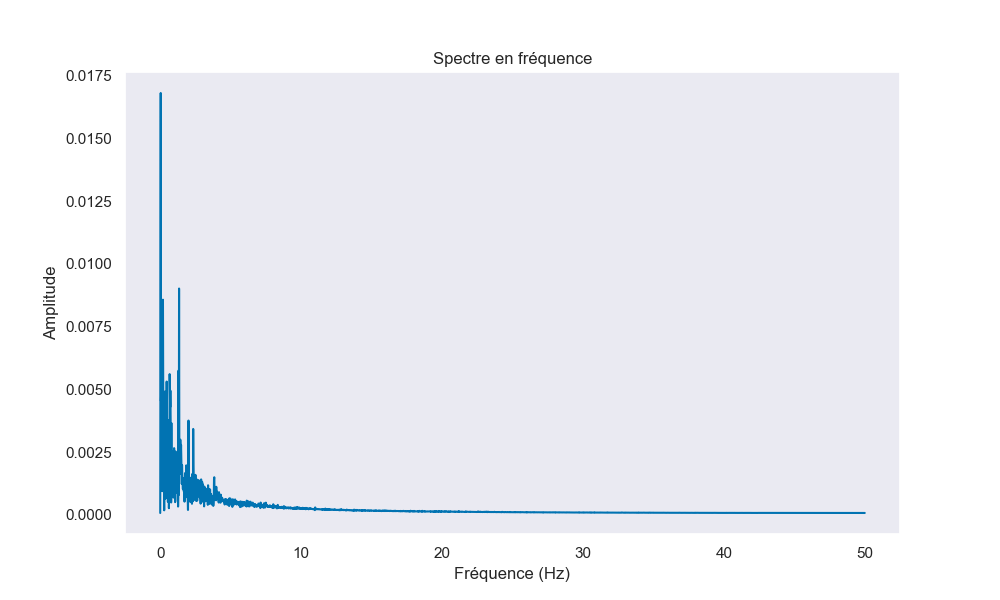

In [116]:
from numpy import correlate


def autocorrelation(sig):
    # Create lag array
    lags = np.arange(-len(sig) + 1, len(sig))
    # Center the autocorrelation result (focus on positive lags)
    autocorr = signal.correlate(sig,sig, mode='full',method='auto')[len(sig)-1:]
    # Create the lag array for positive lags
    positive_lags = lags[len(sig)-1:]
    return positive_lags,autocorr


# for i in df['intensity']:
#     i = i - df['intensity'].mean()
#     df['intensity'][]

lags,autocorr = autocorrelation(df['intensity'] - df['intensity'].mean()) 
# plt.figure(figsize=(16, 9))
# plt.plot(df['t'], d, label='Autocorel', color='purple')
# plt.title('Intensity Autocorrelation')
# plt.xlabel('Lag')
# plt.ylabel('Similarity')
# plt.legend()
# plt.show()
plt.figure(figsize=(16, 9))
plt.plot(lags, autocorr, label='Autocorel', color='purple')
plt.title('Intensity Autocorrelation')
plt.xlabel('Lag')
plt.ylabel('Similarity')
plt.legend()
plt.show()

yf = fft(autocorr)
xf = fftfreq(len(autocorr), T)[:len(autocorr)//2]
plt.figure(figsize=(10, 6))
plt.plot(xf, 2.0/N * np.abs(yf[:len(autocorr)//2]))
plt.title('Spectre en fréquence')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')
# plt.xscale('log')  # Axe des fréquences en logarithmique
# plt.yscale('log')  # Axe des amplitudes en logarithmique
plt.grid()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Exemple de signal brut (à remplacer par votre signal réel)
fs = 1000  # Fréquence d'échantillonnage (Hz)
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 5 * t) + np.random.randn(len(t)) * 0.2

# Exemple de points temporels (onsets) en secondes (à remplacer par vos données réelles)
onsets = [0.1, 0.3, 0.5, 0.7, 0.9]

phase_shift = -60  # Décalage de phase en échantillons

# Convertir les onsets en indices d'échantillons
onset_indices = np.array(onsets) * fs
onset_indices += phase_shift

# Créer le filtre en peigne
bandwidth = 50 # Largeur du pic du filtre
filter_length = len(t)
comb_filter = np.zeros(filter_length)
for onset in onset_indices:
    comb_filter[int(onset):int(onset)+bandwidth] = 1

# Normaliser le filtre en peigne pour conserver l'échelle de l'amplitude
comb_filter /= np.sum(comb_filter)

# Appliquer la convolution entre le signal brut et le filtre en peigne
filtered_signal = convolve(signal, comb_filter, mode='same')

# Affichage des résultats
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t, signal, color='red')
plt.title('Signal brut')

plt.subplot(3, 1, 2)
plt.plot(t, comb_filter, color='yellow')
plt.title('Filtre en peigne')

plt.subplot(3, 1, 3)
plt.plot(t, filtered_signal, color='blue')
plt.title('Signal filtré')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve

# Exemple de signal brut (à remplacer par votre signal réel)
fs = 1000  # Fréquence d'échantillonnage (Hz)
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 5 * t) + np.random.randn(len(t)) * 0.2

# Exemple de points temporels (onsets) en secondes (à remplacer par vos données réelles)
onsets = [0.1, 0.3, 0.5, 0.7, 0.9]

# Convertir les onsets en indices d'échantillons
onset_indices = np.array(onsets) * fs

# Créer le filtre en peigne avec des impulsions fines
filter_length = len(t)
comb_filter = np.zeros(filter_length)
for onset in onset_indices:
    comb_filter[int(onset)] = 1  # Impulsion fine (dirac)

# Normaliser le filtre en peigne pour conserver l'échelle de l'amplitude
comb_filter /= np.sum(comb_filter)

# Appliquer la convolution entre le signal brut et le filtre en peigne
filtered_signal = convolve(signal, comb_filter, mode='same')

# Affichage des résultats
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(t, signal, color='red')
plt.title('Signal brut')

plt.subplot(3, 1, 2)
plt.plot(t, comb_filter, color='yellow')
plt.title('Filtre en peigne')

plt.subplot(3, 1, 3)
plt.plot(t, filtered_signal, color='blue')
plt.title('Signal filtré')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Exemple de signal brut (à remplacer par votre signal réel)
fs = 1000  # Fréquence d'échantillonnage (Hz)
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 5 * t) + np.random.randn(len(t)) * 0.2

# Exemple de points temporels (onsets) en secondes (à remplacer par vos données réelles)
onsets = [0.1, 0.3, 0.5, 0.7, 0.9]

# Convertir les onsets en indices d'échantillons
onset_indices = np.array(onsets) * fs - 60

# Définir une largeur de bande autour de chaque onset
bandwidth = 50  # Nombre d'échantillons autour de chaque onset

# Initialiser le signal filtré
filtered_signal = np.zeros_like(signal)

# Isoler les segments autour de chaque onset
for onset in onset_indices:
    onset = int(onset)
    start = max(onset - bandwidth // 2, 0)
    end = min(onset + bandwidth // 2, len(signal))
    filtered_signal[start:end] = signal[start:end]

# Affichage des résultats
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(t, signal, color='red')
plt.title('Signal brut')

plt.subplot(4, 1, 2)
plt.stem(onsets, np.ones_like(onsets), linefmt='blue', markerfmt='bo', basefmt='k')
plt.title('Onsets')

plt.subplot(4, 1, 3)
comb_filter = np.zeros_like(signal)
for onset in onset_indices:
    onset = int(onset)
    start = max(onset - bandwidth // 2, 0)
    end = min(onset + bandwidth // 2, len(signal))
    comb_filter[start:end] = 1
plt.plot(t, comb_filter, color='yellow')
plt.title('Filtre en peigne')

plt.subplot(4, 1, 4)
plt.plot(t, filtered_signal, color='green')
plt.title('Signal filtré')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Générer des points temporels non équidistants (exemple)
np.random.seed(0)  # Pour la reproductibilité
time_points = np.cumsum(np.random.uniform(0.9, 1.1, 100))  # Série de points temporels non équidistants

# Calcul des intervalles de temps entre les points
time_intervals = np.diff(time_points)

# Estimation du tempo (battements par minute, BPM)
# Suppose que l'unité de temps est la seconde
# Si l'unité de temps est différente, ajustez le facteur en conséquence
tempo = 60 / time_intervals  # Conversion en BPM

# Tracer les points temporels et les intervalles de temps
plt.figure(figsize=(12, 6))

# Tracé des points temporels
plt.subplot(2, 1, 1)
plt.plot(time_points, np.ones_like(time_points), 'bo', label='Points temporels')
plt.xlabel('Temps (secondes)')
plt.ylabel('Amplitude')
plt.title('Points temporels')
plt.legend()

# Tracé du tempogramme
plt.subplot(2, 1, 2)
plt.plot(time_points[1:], tempo, 'r-', marker='o', label='Tempo (BPM)')
plt.xlabel('Temps (secondes)')
plt.ylabel('Tempo (BPM)')
plt.title('Tempogramme')
plt.legend()

plt.tight_layout()
plt.show()


## TODO
